In [2]:
%matplotlib inline

import numpy as np
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import random as rd
import json
import itertools
import re
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
import keras.preprocessing.text as kpt
from keras.models import load_model, model_from_json
import pickle

with open('/root/w210_capstone/data/models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
# load json and create model
json_file = open('/root/w210_capstone/data/models/model_simple_nn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('/root/w210_capstone/data/models/model_simple_nn_WEIGHTS.h5')
# # NDB_tag_unique_unique_dict
with open('/root/w210_capstone/data/models/NDB_tag_unique_unique_dict.json') as f:
    NDB_tag_unique_unique_dict = json.load(f)

# load recipes
# with open('/root/w210_capstone/data/recipe/recipe_clean.json') as f:
#     recipe_clean = json.load(f)
with open('/root/w210_capstone/data/recipe/recipe_clean_USE.json') as f:
    recipe_clean = json.load(f)
    
# nutritional database
nutritional_database = pd.read_csv('/root/w210_capstone/data/nutrient/compiled/nutrition_master_df.csv')

ambiguous = pd.read_csv("/root/w210_capstone/data/recipe/ambiguous_ingredients_from_recipes.csv")
ambiguous = ambiguous.drop_duplicates(subset='JSON_ValueString')

height has been deprecated.



In [3]:
units_of_food_recipe = ["cups", "cup", "c.", "c", 
                        "fl. oz.", "fl oz", "fluid ounce", "fluid ounces", "fl_oz",
                        "gal", "gal.", "gallon", "gallons",
                        "oz", "oz.", "ounce", "ounces", "ouncs",
                        "pt", "pt.", "pint", "pints",
                        "lb", "lb.", "pound", "pounds",
                        "qt", "qt.", "qts", "qts.", "quart", "quarts",
                        "tbsp.", "tbsp", "T", "T.", "tablespoon", "tablespoons", "tbs.", "tbs", "TBSP",
                        "tsp.", "tsp", "t", "t.", "teaspoon", "teaspoons",
                        "g", "g.", "gr", "gr.", "gram", "grams", "gramme", "grammes",
                        "kg", "kg.", "kilogram", "kilograms", "kilogramme", "kilogrammes",
                        "l", "l.", "liter", "liters", "litre", "litres",
                        "mg", "mg.", "milligram", "milligrams", "milligramme", "milligrammes",
                        "ml", "ml.", "milliliter", "milliliters", "millilitre", "millilitres",
                        "pinch", "pinches", "dash", "dashes", "touch", "touches", "handful", "handfuls",
                        "stick", "sticks",
                        "cans", "can",
                        "to taste",
                        "scoop", "scoops",
                        "dollop", "dollops",
                        "sprig", "sprigs",
                       "recipe",
                       "garnish", "garnished",
                       "sprinkle", "spinkled",
                       "ribs", "rib", "stalk",
                       "inch", "inches", "in.",
                       "drizzle", "drizzled",
                       "to taste"]


def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [4]:
def optimize_with_single_n(possible_list, target_nutrs):
    
    recipe_combination = list(itertools.combinations(possible_list, 1))
    cleaned_combination = [x[0] for x in recipe_combination]
    
    print(recipe_combination)
    
    best_loss = {'carb': 1000, 'protein': 1000, 'fat': 1000}
    for iteration in cleaned_combination:
        
        recipe = possible_list[iteration]
        current_carb, current_protein, current_fat = 0, 0, 0
        
        next_carb = current_carb + recipe['carb']
        next_protein = current_protein + recipe['protein']
        next_fat = current_fat + recipe['fat']
        
        if next_carb > target_nutrs['carb'] or next_protein > target_nutrs['protein'] or next_fat > target_nutrs['fat']:
            print('This recipe does not fit the target nutrients')
        
        count = 1
        while next_carb <= target_nutrs['carb'] and next_protein <= target_nutrs['protein'] and next_fat <= target_nutrs['fat']:
            current_carb = next_carb
            current_protein = next_protein
            current_fat = next_fat
            
            next_carb = current_carb + recipe['carb']
            next_protein = current_protein + recipe['protein']
            next_fat = current_fat + recipe['fat']
            count += 1
    
    
        carb_loss = str(target_nutrs['carb'] - current_carb)
        protein_loss = str(target_nutrs['protein'] - current_protein)
        fat_loss = str(target_nutrs['fat'] - current_fat)
        
        
        print('For '+str(count)+" servings of "+iteration+" carb is "+str(current_carb)+", protein is "+str(current_protein)+", fat is "+str(current_fat)+".")
        print('Loss is '+carb_loss+' carbs, '+protein_loss+' protein, '+fat_loss+' fat.')
        print('\n')

In [5]:
def macro_daily_macro_estimation(profile_dict):
    
    profile_dict['macro_nutrients'] = {}
    
    height = profile_dict['characteristics']['height']
    weight = profile_dict['characteristics']['weight']
    age = profile_dict['characteristics']['age']
    calorie_factor = profile_dict['factors']['calorie_factor']
    protein_factor = profile_dict['factors']['protein_factor']
    
    
    # The Original Harris-Benedict Equation   
    calories = 66.473 + 13.7516 * (weight / 2.2)  + 5.0033 * (height * 2.54) - 6.755 * age    
    calories = calories * calorie_factor
    
    ## The Revised Harris-Benedict Equation
    #calories = 88.362 + 13.397 * (weight * 2.2) + 4.799 * (height * 2.54) - 5.6777 * age
    ## The Mifflin St Jeor Equation
    #calories = 5 + 10 * (weight * 2.2) + 6.25 * (height * 2.54) - 5 * age

    # Proteins (g)
    protein = weight * protein_factor
    
    # Fats (g)
    fat = (calories * 0.2) / 9.0
    
    # Carbohydrates (g)
    carbohydrates = (calories - ((protein * 4.0) + (fat * 9.0))) / 4.0
    
    # Fiber (g)
    fiber = (calories / 1000.0) * 14.0
    
    # Cholesterol (mg)
    cholesterol = 300
    
    # Saturated Fat (g)
    saturated_fat = (calories * 0.1 ) / 9.0
    
    # Unsaturated Fat (g)
    unsaturated_fat = (calories * 0.3) / 9.0
    
    # Sugar (g)
    sugar = (calories * 0.1 ) / 9.0
    
    profile_dict['macro_nutrients']['calories'] = calories
    profile_dict['macro_nutrients']['fat'] = fat
    profile_dict['macro_nutrients']['carbohydrates'] = carbohydrates
    profile_dict['macro_nutrients']['fiber'] = fiber
    profile_dict['macro_nutrients']['cholesterol'] = cholesterol
    profile_dict['macro_nutrients']['saturated_fat'] = saturated_fat
    profile_dict['macro_nutrients']['unsaturated_fat'] = unsaturated_fat
    profile_dict['macro_nutrients']['sugar'] = sugar
    profile_dict['macro_nutrients']['protein'] = protein
    
    return profile_dict

In [6]:
def conversion_rate(ingredient_amount, ingredient_unit, nutrition_db_amount, nutrition_db_unit, nutrition_grams):
    
    key_dict = {"cup": {"cups", "cup", "c.", "c"},
        "fluid_ounce": {"fl. oz.", "fl oz", "fluid ounce", "fluid ounces", "fl_oz"},
        "gallon": {"gal", "gal.", "gallon", "gallons"},
        "ounce": {"oz", "oz.", "ounce", "ounces", "ouncs"},
        "pint": {"pt", "pt.", "pint", "pints"},
        "pound": {"lb", "lb.", "pound", "pounds"},
        "quart": {"qt", "qt.", "qts", "qts.", "quart", "quarts"},
        "tablespoon": {"tbsp.", "tbsp", "T", "T.", "tablespoon", "tablespoons", "tbs.", "tbs", "TBSP"},
        "teaspoon": {"tsp.", "tsp", "t", "t.", "teaspoon", "teaspoons"},
        "gram": {"g", "g.", "gr", "gr.", "gram", "grams", "gramme", "grammes"},
        "kilogram": {"kg", "kg.", "kilogram", "kilograms", "kilogramme", "kilogrammes"}
        }
    
    dictionary_conversions = {
        'tablespoon': {
            'teaspoon': 3.0,
            'tablespoon': 1.0,
            'cup': 0.0616115
        },
        'teaspoon': {
            'teaspoon': 1.0,
            'tablespoon': 0.333,
            'cup': 0.0205372         
        },
        'cup': {
            'teaspoon': 48.692115,
            'tablespoon': 16.2307,
            'cup': 1.0,
            'fluid_ounce': 8.11537
        },
        
        'pound': {
            'gram': 16.0,
            'pound': 1.0,
            'kilogram': 0.453592,
            'gram': 453.592
        },
        'ounce': {
            'ounce': 1.0,
            'pound': 0.0625,
            'kilogram': 0.0283495,
            'gram': 28.3495
            
        },
        'kilogram': {
            'ounce': 35.274,
            'pound': 0.0625,
            'kilogram': 2.20462,
            'gram': 1000.0
        },
        'fluid_ounce': {
            'cup': 0.123223
        }
    }
    
    
    for key in key_dict.keys():
        if ingredient_unit in key_dict[key]:
            ingredient_unit = key
        if nutrition_db_unit in key_dict[key]:
            nutrition_db_unit = key
            
    

    if ingredient_unit == 'pound' or ingredient_unit == 'ounce' or ingredient_unit == 'kilogram':
        nutrition_db_unit = 'gram'
                            
    temp_conversation_rate = dictionary_conversions[ingredient_unit][nutrition_db_unit]
            
    if ingredient_unit == 'pound' or ingredient_unit == 'ounce' or ingredient_unit == 'kilogram':
        conversion_rate = float(temp_conversation_rate) * float(ingredient_amount)
    else:
        conversion_rate = float(temp_conversation_rate) * (float(ingredient_amount) / float(nutrition_db_amount)) * float(nutrition_grams)
    
    conversion_rate = float(conversion_rate) / float(nutrition_grams)
    
    return conversion_rate

In [7]:
def food_info_extraction(units_of_food_recipe, nutritional_database, ingredient, nbd_tag):     
    temp_nutrition = nutritional_database[nutritional_database['NDB_NO'] ==  "\"{}\"".format(nbd_tag.strip('"'))][['NDB_NO', 'Measure', 'Weight(g)', ]]    
    temp_nutrition_measure = temp_nutrition['Measure'].get_values()[0]
    
    if 'fl oz' in temp_nutrition_measure:
        temp_nutrition_measure = temp_nutrition_measure.replace('fl oz', 'fl_oz')    
    temp_nutrition_measure = temp_nutrition_measure.replace(',', '')
    temp_nutrition_measure_split = temp_nutrition_measure.split(" ")
    temp_nutrition_grams = temp_nutrition['Weight(g)'].get_values()[0]
    
    nutrition_db_unit_list = list(set(temp_nutrition_measure_split).intersection(units_of_food_recipe))  

    
    
    if len(nutrition_db_unit_list) == 1:
        nutrition_db_unit_use = nutrition_db_unit_list[0]
        temp_nutrition_measure_index = temp_nutrition_measure_split.index(nutrition_db_unit_use)          
        if is_number(temp_nutrition_measure_split[temp_nutrition_measure_index - 1]):
            nutrition_db_amount_use = float(temp_nutrition_measure_split[temp_nutrition_measure_index - 1])
            
    ingredient = ingredient.replace(',', '')
    ingredient_split = ingredient.split(" ")
    ingredient_split_unit_list = list(set(ingredient_split).intersection(units_of_food_recipe))
    
    
    if len(ingredient_split_unit_list) == 1:
        ingredient_split_unit_use = ingredient_split_unit_list[0]
        ingredient_split_unit_index = ingredient_split.index(ingredient_split_unit_use) 
                
        if is_number(temp_nutrition_measure_split[ingredient_split_unit_index - 1]):
            ingredient_amount_use = float(ingredient_split[ingredient_split_unit_index - 1])
            
    
    if ingredient_split_unit_use == 'pound' or ingredient_split_unit_use == 'pounds' or ingredient_split_unit_use == 'ounce' or ingredient_split_unit_use == 'kilogram':
        nutrition_db_unit_use = 'gram'
        nutrition_db_amount_use = 'gram'
    
    return ingredient_amount_use, ingredient_split_unit_use, nutrition_db_amount_use, nutrition_db_unit_use, temp_nutrition_grams

In [8]:
def ambiguous_coversion_factor(grams, nutritional_database, nbd_tag):
    
    try:
        temp_nutrition = nutritional_database[nutritional_database['NDB_NO'] ==  "\"{}\"".format(nbd_tag.strip('"'))][['NDB_NO', 'Measure', 'Weight(g)', ]]    
    except:
        temp_nutrition = nutritional_database[nutritional_database['NDB_NO'] ==  "\"{}\"".format(nbd_tag)][['NDB_NO', 'Measure', 'Weight(g)', ]]    
    
    temp_nutrition_measure = temp_nutrition['Weight(g)'].get_values()[0]
    
    return float(grams) / float(temp_nutrition_measure)
    

In [9]:
# recipe_id_list = list(recipe_clean.keys())[:1]
recipe_id_list = list(recipe_clean.keys())
recipe_id_list = recipe_id_list[:50]


recipe_itr = 0
for recipe_id in recipe_id_list:
#     print(recipe_id)
    conversion_rate_factor_list = []    
    itr = 0
    for tag in recipe_clean[recipe_id]['NDB_NO_tags']:
        if tag != 'np.nan' and tag != '':            
            split_ingredient = recipe_clean[recipe_id]['ingredients'][itr].split(" ")
            split_ingredient_filter = list(filter(None, split_ingredient))
            ingredient_new_temp = " ".join(split_ingredient_filter)

            if ingredient_new_temp.strip("'") in ambiguous['JSON_ValueString'].values:               
                conversion_rate_factor = ambiguous_coversion_factor(ambiguous[ambiguous['JSON_ValueString'] == ingredient_new_temp.strip("'")]['grams'].get_values()[0], nutritional_database, tag) 
                conversion_rate_factor_list.append(conversion_rate_factor)
            else:                
                try:

                    ingredient_amount_use, ingredient_split_unit_use, nutrition_db_amount_use, nutrition_db_unit_use, temp_nutrition_grams = food_info_extraction(units_of_food_recipe, 
                                         nutritional_database, 
                                         ingredient_new_temp, 
                                         tag)     

                    conversion_rate_factor = conversion_rate(ingredient_amount_use, ingredient_split_unit_use, nutrition_db_amount_use, nutrition_db_unit_use, temp_nutrition_grams)
                    conversion_rate_factor_list.append(conversion_rate_factor)
                except:
                    print("\t**********FAILED!**********")
                    print(recipe_id)
                    print(ingredient_new_temp)
        else:
            conversion_rate_factor_list.append('')
                
        itr += 1
        recipe_clean[recipe_id]['conversion_rate_factor'] = conversion_rate_factor_list
    recipe_itr += 1

In [10]:
macro_list = \
['Energy (kcal)', 'Total lipid (fat) (g)', 'Carbohydrate, by difference (g)', 
'Fiber, total dietary (g)', 'Cholesterol (mg)', 
'Fatty acids, total saturated (g)',
'Fatty acids, total monounsaturated (g)', 'Fatty acids, total polyunsaturated (g)', 
 'Fatty acids, total trans (g)', 'Protein (g)', 'Sugars, total (g)']

micro_list = \
['Iron, Fe (mg)', 'Magnesium, Mg (mg)', 'Manganese, Mn (mg)', 'Thiamin (mg)', 
 'Vitamin D (D2 + D3) (µg)']

keep_list = ['NDB_NO', 'Measure', 'Weight(g)', 'Description', 'Category']

macro_micro_sum_list = macro_list + micro_list
macro_micro_list = keep_list + macro_list + micro_list
ndb_columns_filtered = nutritional_database[macro_micro_list]

In [11]:
# recipe_id_list = list(recipe_clean.keys())[:1]
recipe_id_list = list(recipe_clean.keys())
recipe_id_list = recipe_id_list[:50]

recipe_itr = 0
for recipe_id in recipe_id_list:
    try:
        print(recipe_id)
        print(recipe_clean[recipe_id]['name'])
        itr = 0
        df_list = []
        for tag in recipe_clean[recipe_id]['NDB_NO_tags']:
            if tag != 'np.nan' and tag != '':
                df_list.append(ndb_columns_filtered[ndb_columns_filtered['NDB_NO'] ==  "\"{}\"".format(tag.strip('"'))][macro_micro_sum_list])
            itr += 1
        master_df = pd.concat(df_list).sum()

        recipe_clean[recipe_id]['carb'] = master_df['Carbohydrate, by difference (g)']
        recipe_clean[recipe_id]['fat'] = master_df['Total lipid (fat) (g)']
        recipe_clean[recipe_id]['protein'] = master_df['Protein (g)']
    except:
        del recipe_clean[recipe_id]

RECIPE_76881
Shrimp Potstickers
RECIPE_69129
Avocado Beet Pea and Cucumber Salad
RECIPE_78461
Fried Green Tomatoes
RECIPE_78505
Parmesan Kale Chips
RECIPE_49004
Jades BBP (Breakfast Bread Pudding)
RECIPE_67528
Tuscan Chicken Pizza Sandwich
RECIPE_41736
Frittata with Tuna and Tomatoes
RECIPE_12111
Butter Pie Crust Dough
RECIPE_24578
Chicken Soup with Stars and Meatballs
RECIPE_13188
Rum-Raisin Pound Cake
RECIPE_18440
Super Potato Salad
RECIPE_71831
Peeky-Toe Crab and Green Tomato Salad with Chilled Gazpacho Sauce
RECIPE_63893
Chorizo Puffs (BunUelos de Chorizo)
RECIPE_44107
Honey Whole-Wheat Pancakes with Honey Lime Butter
RECIPE_8669
Roast Chicken with Dried Fruit and Almonds
RECIPE_52892
Individual Peach Tarte Tatin
RECIPE_84387
Champagne and Berry Soup
RECIPE_71937
Spanish Potato Salad
RECIPE_21388
Ruby Red Margarita
RECIPE_14063
Grilled New York Steaks with San Marzano Sauce
RECIPE_61308
Mediterranean Tuna Wrap
RECIPE_83991
Fritatten Soup with Romaine
RECIPE_69249
Endive and Grape S

In [13]:
mikegruzynski = {
    
    "characteristics":{
        'height': 76.0,
        'weight': 255.0,
        'age': 28.0
        },
    "factors":{
        'calorie_factor': 1.375,
        'protein_factor': 0.75
    },
    "micro_nutrients":{
        'iron': 8,
        'magnesium': 420,
        'maganese': 2.3,
        'thiamin': 1.2,
        'Vitamin D (D2 + D3)': 15        
    }
    
}

mikegruzynski = macro_daily_macro_estimation(mikegruzynski)
weekly_macro_nutrients = dict([(x, mikegruzynski['macro_nutrients'][x]*3) for x in mikegruzynski['macro_nutrients'].keys()])

In [14]:
recipes = {}
for recipe_id in list(recipe_clean.keys())[:50]:
    recipes[recipe_id] = {'carb': recipe_clean[recipe_id]['carb'], 
                          'protein': recipe_clean[recipe_id]['protein'], 
                          'fat': recipe_clean[recipe_id]['fat']}
weekly_macro_nutrients_use = {'carb': weekly_macro_nutrients['carbohydrates'], 
                              'fat': weekly_macro_nutrients['fat'], 
                              'protein': weekly_macro_nutrients['protein']}

In [15]:
current_nutrients = {'carb': 0, 'protein': 0, 'fat': 0}
total_loss = weekly_macro_nutrients

In [16]:
optimize_with_single_n(recipes, weekly_macro_nutrients_use)

[('RECIPE_76881',), ('RECIPE_69129',), ('RECIPE_78461',), ('RECIPE_78505',), ('RECIPE_49004',), ('RECIPE_67528',), ('RECIPE_41736',), ('RECIPE_12111',), ('RECIPE_24578',), ('RECIPE_13188',), ('RECIPE_18440',), ('RECIPE_71831',), ('RECIPE_63893',), ('RECIPE_44107',), ('RECIPE_8669',), ('RECIPE_52892',), ('RECIPE_84387',), ('RECIPE_71937',), ('RECIPE_21388',), ('RECIPE_14063',), ('RECIPE_61308',), ('RECIPE_83991',), ('RECIPE_69249',), ('RECIPE_45110',), ('RECIPE_65290',), ('RECIPE_62881',), ('RECIPE_61302',), ('RECIPE_60641',), ('RECIPE_63775',), ('RECIPE_49066',), ('RECIPE_67146',), ('RECIPE_55944',), ('RECIPE_41612',), ('RECIPE_63951',), ('RECIPE_67225',), ('RECIPE_72219',), ('RECIPE_69809',), ('RECIPE_78967',), ('RECIPE_25618',), ('RECIPE_51469',), ('RECIPE_80454',), ('RECIPE_67456',), ('RECIPE_12451',), ('RECIPE_24481',), ('RECIPE_66587',), ('RECIPE_80100',), ('RECIPE_10144',), ('RECIPE_83998',), ('RECIPE_71531',), ('RECIPE_72342',)]
For 4 servings of RECIPE_76881 carb is 1101.84, pr

In [17]:
import random

In [18]:
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

def optimize_with_multiple_n(possible_list, target_nutrs, number_recipes, random_itr, minimum = 0):
    
    recipe_combination = list(itertools.combinations(possible_list, number_recipes))
    cleaned_combination = recipe_combination
    random.seed(random_itr)
    cleaned_combination_use = random.sample(cleaned_combination, len(cleaned_combination))
        
    counter = 0
    best_loss = sum(target_nutrs.values())
    best_recipes = None
    best_weights = None
    each_round_list = []
    for iteration in cleaned_combination_use:
        print("Optimizing combination "+str(counter + 1))
        print("\n")
        macro_vector = [(possible_list[x]['carb'], possible_list[x]['protein'], possible_list[x]['fat']) for x in iteration]

        # define objective function as total macro loss with minimization
        c = [sum(target_nutrs.values())]+[-sum(x) for x in macro_vector]

        # define constraints, add 0 to account for constant
        carb_const = [0]+[x[0] for x in macro_vector]
        protien_const = [0]+[x[1] for x in macro_vector]
        fat_const = [0]+[x[2] for x in macro_vector]
        A = [carb_const, protien_const, fat_const]

        # define inequalities
        b = target_nutrs.values()

        # define bounds, note x0 must be 1 to define minimization
        # might want minimum of each
        x0_bounds = (1, 1)
        var_bounds = [x0_bounds]+[(minimum, None) for x in range(len(iteration))]


        #run optimization
        res = linprog(c, A_ub=A, b_ub=list(b), bounds=var_bounds, options={"disp": False})

        each_round_list.append(res['fun'])

        if res['fun'] < best_loss:

            print('The new best loss is '+str(round(res['fun'], 4)))
            print('\n')
            best_loss = res['fun']

            best_recipes = iteration
            best_weights = res['x'][1:]

            if isclose(round(res['fun'], 4), 0.0, rel_tol=0.1, abs_tol=0.1):
                break
            else:
                continue

        counter = counter + 1

    
        
    return each_round_list, best_recipes, best_weights

In [19]:
each_round_list, best_recipes, best_weights = optimize_with_multiple_n(recipes, weekly_macro_nutrients_use, 3, 100)

Optimizing combination 1


The new best loss is 218.0604


Optimizing combination 1


Optimizing combination 2


Optimizing combination 3


Optimizing combination 4


The new best loss is 159.5205


Optimizing combination 4


Optimizing combination 5


Optimizing combination 6


Optimizing combination 7


Optimizing combination 8


Optimizing combination 9


The new best loss is -0.0




In [20]:
print(each_round_list)
print(best_recipes)
print(best_weights)

[218.06039392172448, 218.74049142507425, 473.78263368685907, 220.40457836886731, 159.52050365709601, 189.08339251665143, 504.37703902344651, 210.52860340832228, 223.22844759068613, 201.22326917316224, -0.0]
('RECIPE_78505', 'RECIPE_14063', 'RECIPE_80454')
[ 66.25113294   8.62220518  42.86313973]


In [46]:
each_round_list2, best_recipes2, best_weights2 = optimize_with_multiple_n(recipes, weekly_macro_nutrients_use, 3, 334)

Optimizing combination 1


The new best loss is 473.7826


Optimizing combination 1


The new best loss is 246.5924


Optimizing combination 1


The new best loss is 220.8788


Optimizing combination 1


The new best loss is 196.5572


Optimizing combination 1


The new best loss is 196.4217


Optimizing combination 1


Optimizing combination 2


Optimizing combination 3


Optimizing combination 4


The new best loss is 190.5024


Optimizing combination 4


Optimizing combination 5


The new best loss is -0.0




In [47]:
print(each_round_list2)
print(best_recipes2)
print(best_weights2)

[473.78263368685907, 246.59242056573316, 220.87876448745081, 196.55724765500128, 196.42173941395635, 397.57170812421896, 428.11384205670288, 411.27700669771201, 190.50242017825917, 218.37281131235019, -1.1368683772161603e-13]
('RECIPE_24578', 'RECIPE_60641', 'RECIPE_63951')
[  5.63997108  63.38298069   1.36999231]


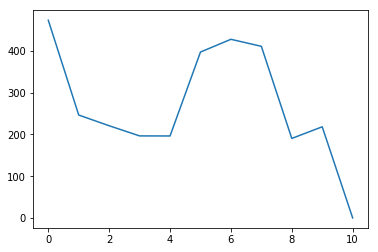

In [48]:
import matplotlib.pyplot as plt
plt.plot(each_round_list2)


In [21]:
recipes_new, weights_new

NameError: name 'recipes_new' is not defined